<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/LIME_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=16be9820303164abde59a5cff49bffaffec31282526d127e9e30e861c0c5f5a3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=edece096edaa737cb6e91da11cf5a2fa118fe0a6c76e9645f1e10502a3394ed2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
# Core ML and data handling
import torch
from torch import nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import os
from torchvision.transforms import Grayscale

# Data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# Image processing and LIME
from PIL import Image
from efficientnet_pytorch import EfficientNet
from lime import lime_image
from albumentations import pytorch as AT
from skimage.segmentation import mark_boundaries

# Utilities
from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd '/content/drive/MyDrive/train_test'

/content/drive/MyDrive/train_test


In [7]:
# Define transformations, including converting to grayscale and data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a consistent size
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Randomly crop and resize the image
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet statistics
])

In [8]:
# Path to the root directory of your train and test data in Google Drive
train_data_path = '/content/drive/MyDrive/train_test/train/train_d'
test_data_path = '/content/drive/MyDrive/train_test/test/test_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label


In [10]:
# Load custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

In [11]:
# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
len(train_dataloader) , len(test_dataloader)

(23, 8)

In [13]:
len(train_dataset) , len(test_dataset)

(725, 248)

In [14]:
class_names=emotion_labels
class_names

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

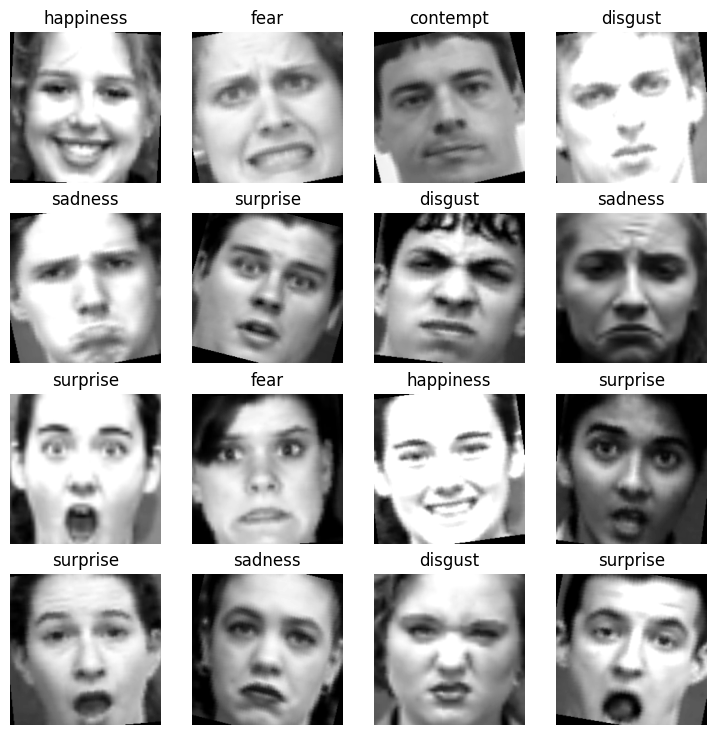

In [15]:
# plot more images
torch.manual_seed(42)
fig =plt.figure(figsize = (9,9))
rows , cols = 4,4

transform = Grayscale(num_output_channels=1)

for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_dataset) , size =[1]).item()
  img , label = train_dataset[random_idx]

  img= transform(img)

  fig.add_subplot(rows,cols , i)
  plt.imshow(img.squeeze() ,cmap="gray")
  plt.title(emotion_labels[label])
  plt.axis(False)

In [16]:
# Lets check out what we have created
print(f"dataloaders : {train_dataloader , test_dataloader}")
print(f" length of train_dataloader : {len(train_dataloader)} batches of {batch_size}....")
print(f" length of test_dataloader : {len(test_dataloader)} batches of {batch_size}...")

dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x7bdf1f2e1f00>, <torch.utils.data.dataloader.DataLoader object at 0x7bdf1f2e3c70>)
 length of train_dataloader : 23 batches of 32....
 length of test_dataloader : 8 batches of 32...


In [17]:
# Check out whats inside the training dataloader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [18]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [23]:
from pathlib import Path

##EfficientNet

In [24]:
# Define the model architecture with pretrained weights
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')

num_classes = 7
efficientnet_model._fc = torch.nn.Linear(efficientnet_model._fc.in_features, num_classes)

# Load the saved state dict
MODEL_SAVE_PATH = Path("Emotion_Analysis_Model/efficientnet_model.pth")

# Load the state dict into the model
efficientnet_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

Loaded pretrained weights for efficientnet-b0


<ipython-input-24-bd3dcceba3b3>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [26]:
# Ensure the model is on the right device
efficientnet_model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [29]:
# Dictionary to hold one random image per label
unique_images = {}
num_labels = 7  # Total number of unique labels

# Iterate through the test dataloader to find one image per label
for test_features_batch, test_labels_batch in test_dataloader:
    for i in range(len(test_features_batch)):
        label = test_labels_batch[i].item()

        # Check if we already have an image for this label
        if label not in unique_images:
            unique_images[label] = test_features_batch[i]

        # Stop if we have one image for each label
        if len(unique_images) == num_labels:
            break
    if len(unique_images) == num_labels:
        break

In [30]:
# Convert each image to numpy array and prepare for LIME
example_images_np = {
    label: (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    for label, image in unique_images.items()
}

In [35]:
# Define the prediction function for LIME
def predict_fn(images):
    # Convert list of images to tensor batch
    images = [transforms.ToTensor()(image).unsqueeze(0).to(device) for image in images]
    batch = torch.cat(images).to(device)

    # Get predictions
    with torch.no_grad():
        probs = torch.nn.functional.softmax(efficientnet_model(batch), dim=1)

    return probs.cpu().numpy()

In [36]:
# Step 3: Create a LIME explainer instance
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

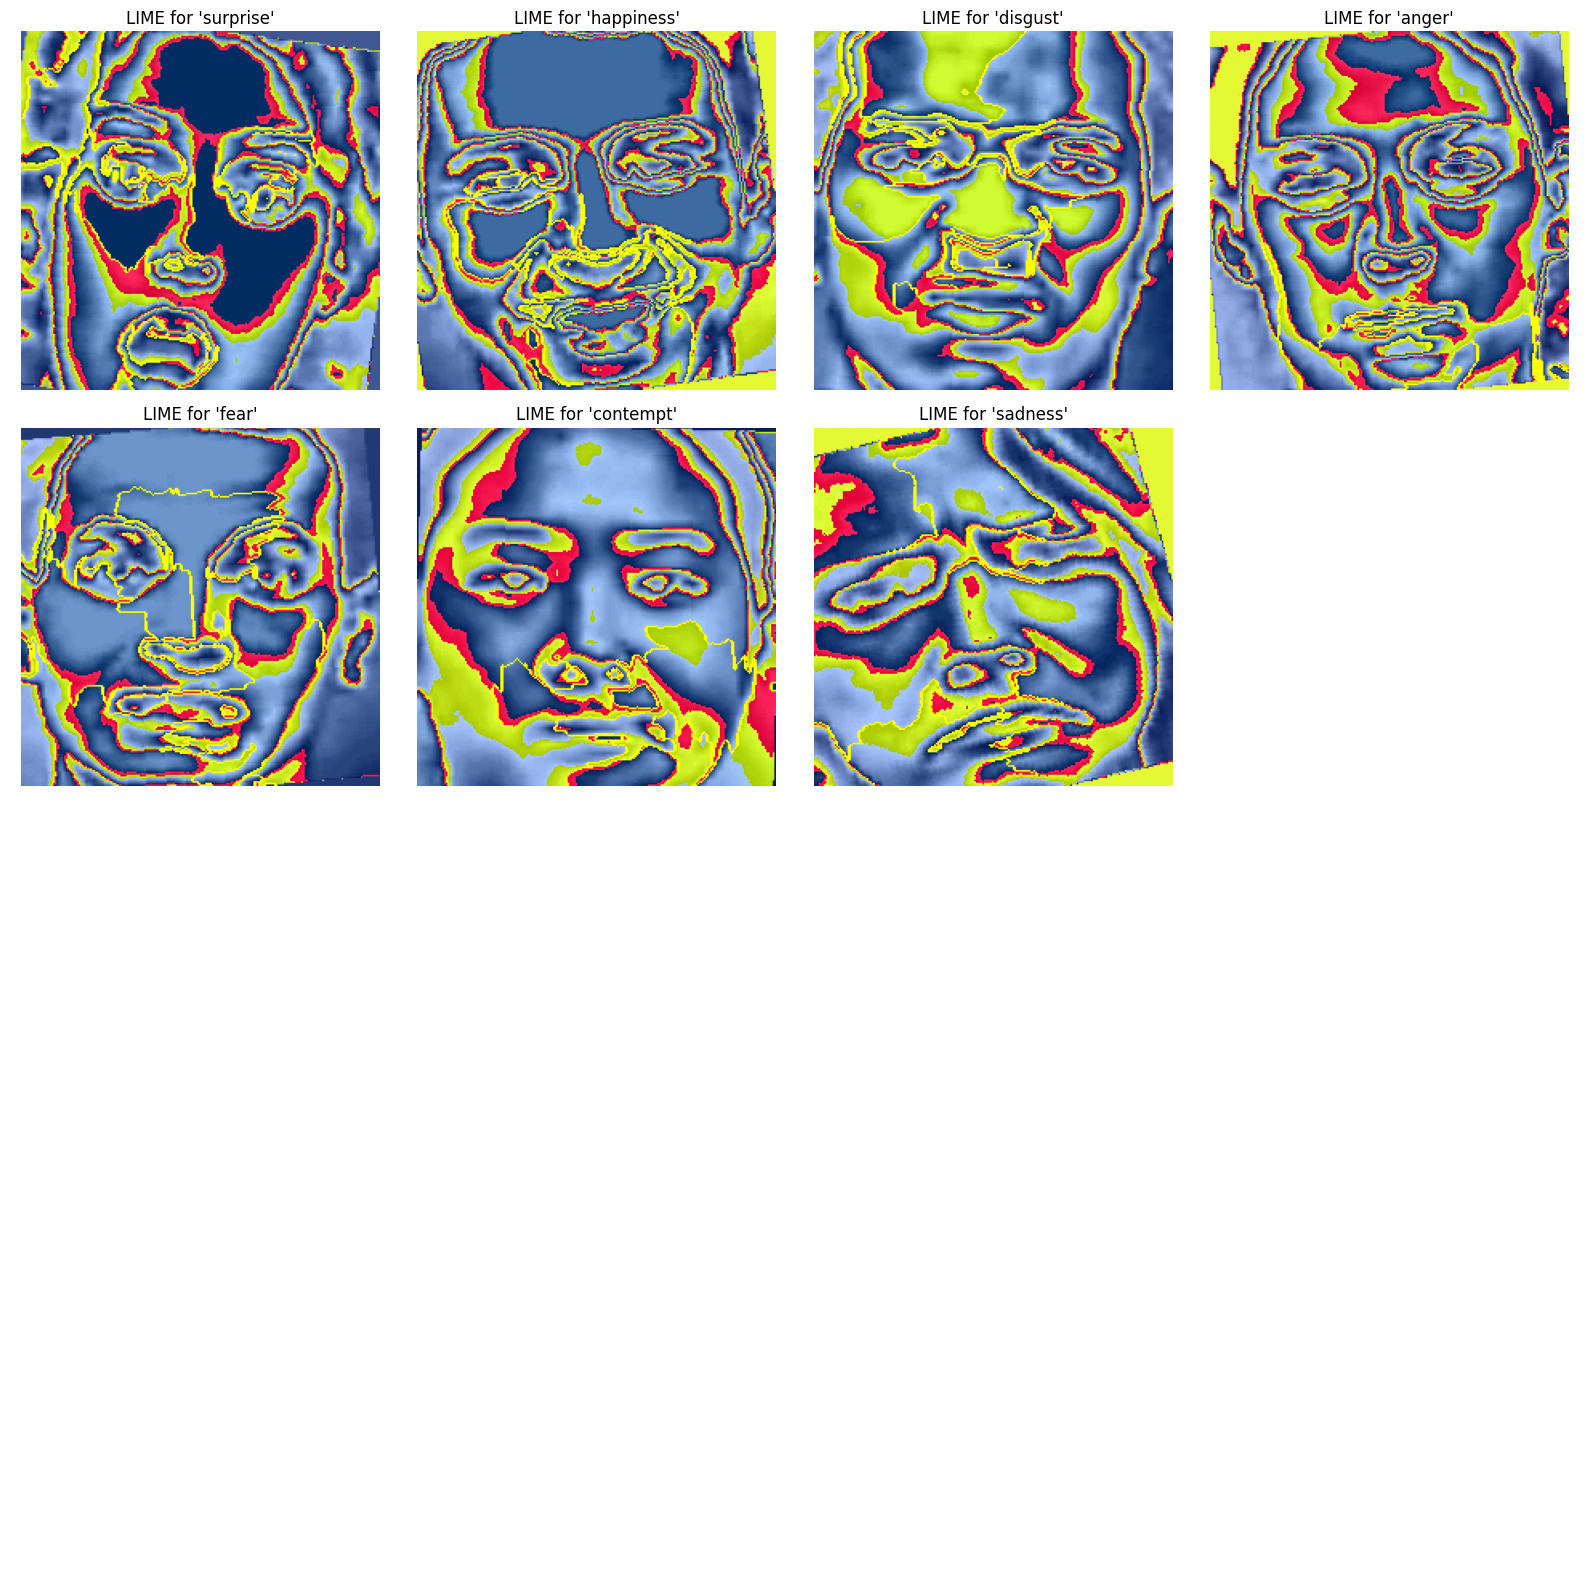

In [37]:
# Set up the grid dimensions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 4x4 grid for easy iteration

# Loop through each unique label and generate LIME explanations
for idx, (label, example_image_np) in enumerate(example_images_np.items()):
    # Step 4: Generate the explanation
    explanation = explainer.explain_instance(
        example_image_np,
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Step 5: Get the heatmap for the top class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Step 6: Display the heatmap in the 4x4 grid
    axes[idx].imshow(mark_boundaries(temp / 255.0, mask))
    axes[idx].set_title(f"LIME for '{emotion_labels[label]}'")
    axes[idx].axis("off")

# Hide remaining empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


##ResNet50

In [38]:
# Define the model architecture with pretrained weights
resnet50_model = models.resnet50(pretrained=True)

num_classes = 7
resnet50_model.fc = torch.nn.Linear(resnet50_model.fc.in_features, num_classes)

# Load the saved state dict
MODEL_SAVE_PATH = Path("Emotion_Analysis_Model/ResNet50.pth")

# Load the state dict into the model
resnet50_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]
<ipython-input-38-927e3cacaf6b>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

<All keys matched successfully>

In [39]:
# Ensure the model is on the correct device
resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
# Dictionary to hold one random image per label
unique_images = {}
num_labels = 7  # Total number of unique labels

# Iterate through the test dataloader to find one image per label
for test_features_batch, test_labels_batch in test_dataloader:
    for i in range(len(test_features_batch)):
        label = test_labels_batch[i].item()

        # Check if we already have an image for this label
        if label not in unique_images:
            unique_images[label] = test_features_batch[i]

        # Stop if we have one image for each label
        if len(unique_images) == num_labels:
            break
    if len(unique_images) == num_labels:
        break

In [42]:
# Convert each image to numpy array and prepare for LIME
example_images_np = {
    label: (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    for label, image in unique_images.items()
}

In [43]:
# Define the prediction function for LIME
def predict_fn(images):
    # Convert list of images to tensor batch
    images = [transforms.ToTensor()(image).unsqueeze(0).to(device) for image in images]
    batch = torch.cat(images).to(device)

    # Get predictions
    with torch.no_grad():
        probs = torch.nn.functional.softmax(resnet50_model(batch), dim=1)

    return probs.cpu().numpy()

In [44]:
# Step 3: Create a LIME explainer instance
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

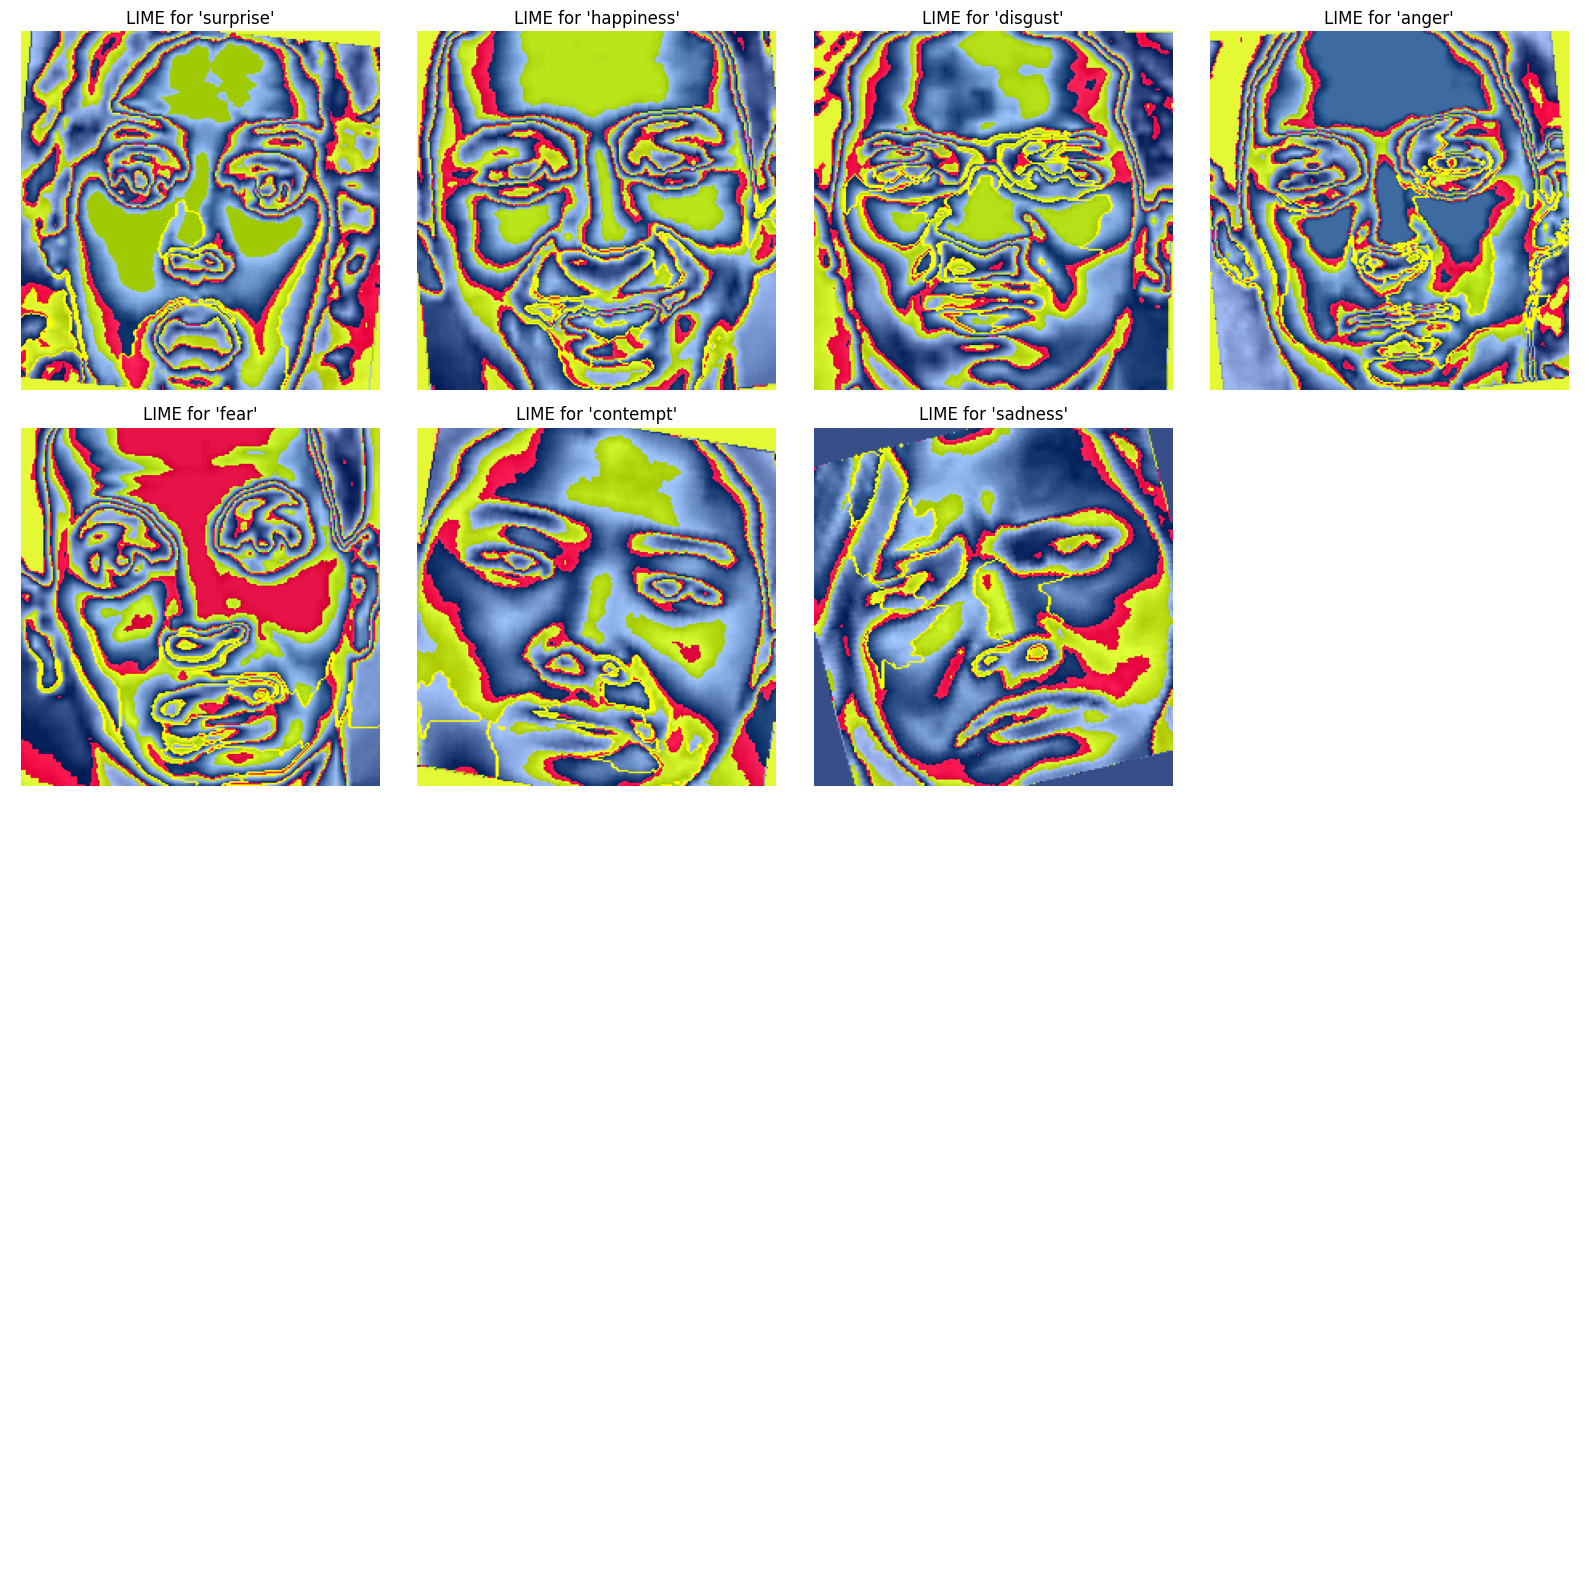

In [45]:
# Set up the grid dimensions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 4x4 grid for easy iteration

# Loop through each unique label and generate LIME explanations
for idx, (label, example_image_np) in enumerate(example_images_np.items()):
    # Step 4: Generate the explanation
    explanation = explainer.explain_instance(
        example_image_np,
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Step 5: Get the heatmap for the top class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Step 6: Display the heatmap in the 4x4 grid
    axes[idx].imshow(mark_boundaries(temp / 255.0, mask))
    axes[idx].set_title(f"LIME for '{emotion_labels[label]}'")
    axes[idx].axis("off")

# Hide remaining empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()
